In [2]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import astropy.constants as const
import numpy as np
import tayph.operations as ops
from orbit_fitting import keplerian,rot_orbital_elements,kepler_III
plt.style.use('dark_background')

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

### This notebook is for interactively plotting a Keplerian orbit and its coordinate and velocity vectors, evaluating the transit geometry.

Run the below cell that defines the plot and the interactive sliders. The N point multiplier slider adjust the number of evaluations of the orbit, in transits are missed for very fast orbits.
The panels are plotted in a 2x2 layout, meant for full-screen interaction.

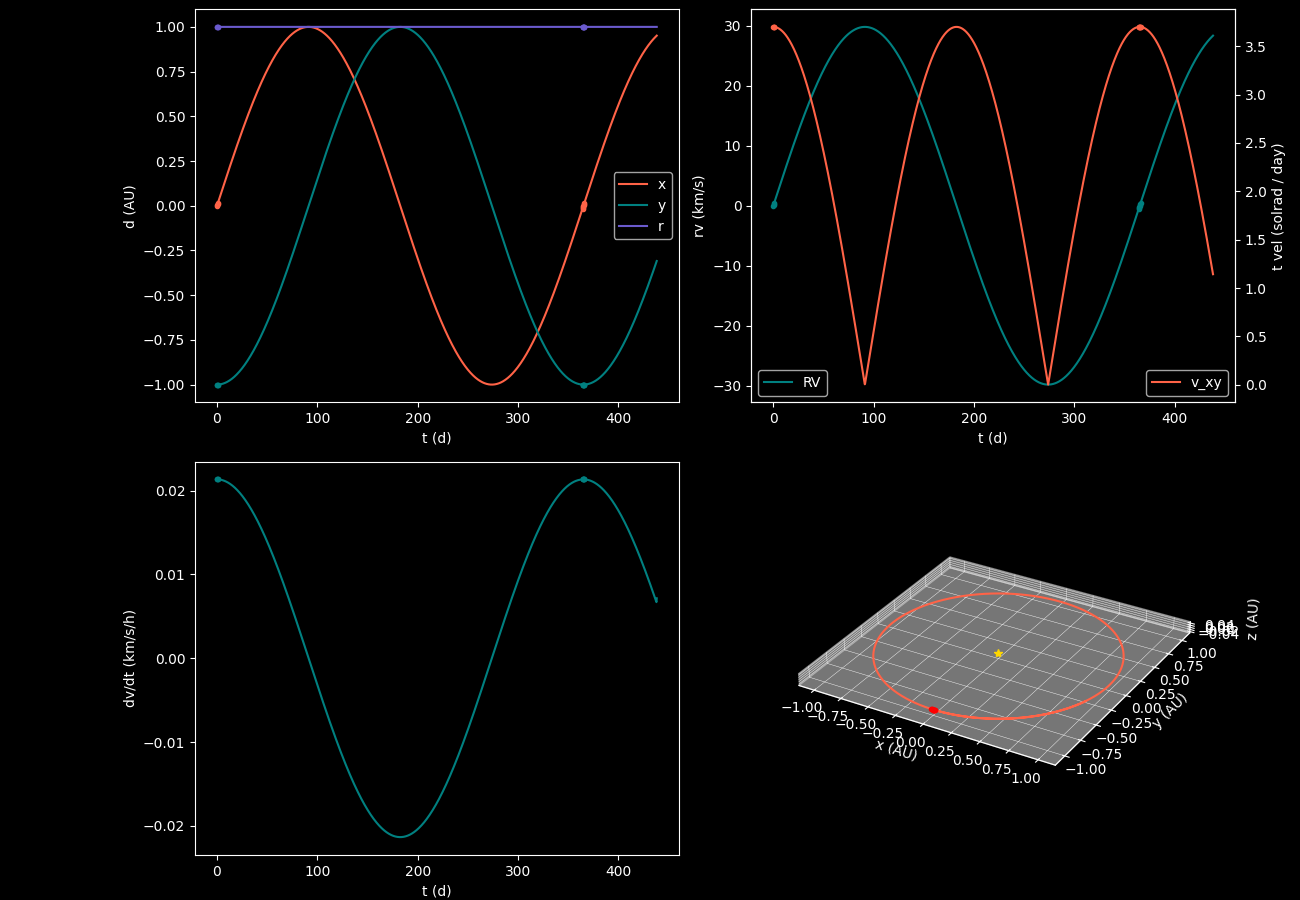

In [19]:
output = widgets.Output()
with output:
    fig = plt.figure(figsize=(13,9))
    ax0 = fig.add_subplot(2,2,1)
    ax1 = fig.add_subplot(2,2,2)
    ax2 = ax1.twinx()
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4,projection='3d')

plt.subplots_adjust(wspace=0.15,hspace=0.15,left=0.15,right=0.95,top=0.99,bottom=0.05)

slider_a = widgets.FloatLogSlider(value=1.0, min=-2, max=1.5, step=0.01, description='a (AU)')
slider_e = widgets.FloatSlider(value=0.0, min=0.0, max=0.999, step=0.02, description=f'e')
slider_w = widgets.FloatSlider(value=90, min=0, max=360, step=2, description=f'w (deg))')
slider_i = widgets.FloatSlider(value=0.0, min=-90, max=90, step=0.5, description=f'i (deg)')
slider_W = widgets.FloatSlider(value=180.0, min=0.0, max=360, step=5, description='Omega (deg)')
slider_M = widgets.FloatSlider(value=1.0, min=0.1, max=4, step=0.1, description=f'Ms (solar)')
slider_n_steps = widgets.FloatSlider(value=1.0, min=1.0, max=20, step=1, description=f'N point multiplier')
R_limit = 4.0*const.R_sun.value #solar radii.
au = const.au.value
msun = const.M_sun.value




def calc_coords(s_a,s_e,s_w,s_i,s_W,s_M,s_N):
    a_act,e_act,w_act,i_act,W_act,M_act,n_act = s_a, s_e, s_w,s_i,s_W,s_M,s_N

    P = kepler_III(a_act*au,M_act*msun)

    n_steps = min([int(P/3600*1.2*4),1500])*int(n_act) #We do 1.2 periods for each orbit, and we do 2 steps per hour. That's P/3600 times 2*1.2.

    t = np.linspace(0,P/3600/24*1.2,n_steps)
    dt = (t[1]-t[0])#In days

    r,T,x,y,vx,vy = keplerian(t,a_au=a_act,e=e_act,M_Msun=M_act)
    z,vz = x*0.0,vx*0.0
    x,y,z    = rot_orbital_elements(x,y,z,inc = np.radians(i_act),omega=np.radians(w_act),Omega=np.radians(W_act))
    vx,vy,vz = rot_orbital_elements(vx,vy,vz,inc = np.radians(i_act),omega=np.radians(w_act),Omega=np.radians(W_act))
    dvdt = ops.derivative(np.array(vy))/dt/24/1e3 #Acceleration in m/s per day *24/1e3 = km/s/h

    sel = (np.abs(x)<R_limit)&(y<0)&(np.abs(z)<R_limit)

    return(t,r,x,y,z,vx,vy,vz,dvdt,sel)





t,r,x,y,z,vx,vy,vz,dvdt,sel = calc_coords(slider_a.value,slider_e.value,slider_w.value,slider_i.value,slider_W.value,slider_M.value,slider_n_steps.value)
xline, = ax0.plot(t,x/au,label='x',color='tomato')
yline, = ax0.plot(t,y/au,label='y',color='teal')
rline, = ax0.plot(t,r/au,label='r',color='slateblue')
xline_s, = ax0.plot(t[sel],x[sel]/au,'.',color='tomato')
yline_s, = ax0.plot(t[sel],y[sel]/au,'.',color='teal')
rline_s, = ax0.plot(t[sel],r[sel]/au,'.',color='slateblue')
vline, = ax1.plot(t,vy/1e3,color='teal',label='RV')
vline_s, = ax1.plot(t[sel],vy[sel]/1e3,'.',color='teal')
tline, = ax2.plot(t,np.sqrt(vx**2+vz**2)/(const.R_sun.value)*24*3600,color='tomato',label='v_xy')
tline_s, = ax2.plot(t[sel],np.sqrt(vx[sel]**2+vz[sel]**2)/(const.R_sun.value)*24*3600,'.',color='tomato')
aline, = ax3.plot(t,dvdt,color='teal')
aline_s, = ax3.plot(t[sel],dvdt[sel],'.',color='teal')
ax4.plot(x/au,y/au,z/au,label='Orbit',color='tomato')
ax4.plot(x[sel]/au,y[sel]/au,z[sel]/au,'.',color='red')


ax0.set_xlabel('t (d)')
ax0.set_ylabel('d (AU)')
ax0.legend()

ax1.set_xlabel('t (d)')
ax1.set_ylabel('rv (km/s)')
ax2.set_ylabel('t vel (solrad / day)')
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

ax3.set_xlabel('t (d)')
ax3.set_ylabel('dv/dt (km/s/h)')
# ax3.yaxis.tick_right()
# ax3.yaxis.set_label_position('right')

ax4.plot(0,0,0,'*',color='gold')
ax4.set_xlabel('x (AU)')
ax4.set_ylabel('y (AU)')
ax4.set_zlabel('z (AU)')
ax4.set_aspect('equal')
ax4.xaxis._axinfo["grid"]['linewidth'] = 0.3
ax4.yaxis._axinfo["grid"]['linewidth'] = 0.3
ax4.zaxis._axinfo["grid"]['linewidth'] = 0.3



def update_lines(t,r,x,y,z,vx,vy,vz,dvdt,sel):
    for l in [xline,yline,rline,vline,tline,aline]:
        l.set_xdata(t)
    for l in [xline_s,yline_s,rline_s,vline_s,tline_s,aline_s]:
        l.set_xdata(t[sel])

    xline.set_ydata(x/au)
    yline.set_ydata(y/au)
    rline.set_ydata(r/au)
    xline_s.set_ydata(x[sel]/au)
    yline_s.set_ydata(y[sel]/au)
    rline_s.set_ydata(r[sel]/au)
    vline.set_ydata(vy/1e3)
    vline_s.set_ydata(vy[sel]/1e3)
    tline.set_ydata(np.sqrt(vx**2+vz**2)/(const.R_sun.value)*24*3600)
    tline_s.set_ydata(np.sqrt(vx[sel]**2+vz[sel]**2)/(const.R_sun.value)*24*3600)

    aline.set_ydata(dvdt)
    aline_s.set_ydata(dvdt[sel])

    
    ax4.clear()
    ax4.plot(x/au,y/au,z/au,label='Orbit',color='tomato')
    ax4.plot(x[sel]/au,y[sel]/au,z[sel]/au,'.',color='red')
    ax4.plot(0,0,0,'*',color='gold')
    ax4.set_xlabel('x (AU)')
    ax4.set_ylabel('y (AU)')
    ax4.set_zlabel('z (AU)')
    ax4.set_aspect('equal')
    ax4.xaxis._axinfo["grid"]['linewidth'] = 0.3
    ax4.yaxis._axinfo["grid"]['linewidth'] = 0.3
    ax4.zaxis._axinfo["grid"]['linewidth'] = 0.3
    for axx in [ax0,ax1,ax2,ax3]:
        # axx.set_xlim(min(t),max(t))
        axx.relim()
        axx.autoscale()

        

# # callback functions
def update_a(change):
    t,r,x,y,z,vx,vy,vz,dvdt,sel = calc_coords(slider_a.value,slider_e.value,slider_w.value,slider_i.value,slider_W.value,slider_M.value,slider_n_steps.value)
    update_lines(t,r,x,y,z,vx,vy,vz,dvdt,sel)
    fig.canvas.draw()
#     cline.set_ydata(cont(v00,change.new,slider_c1.value*c1s,slider_c2.value*c2s,slider_c3.value*c3s))
#     fig.canvas.draw()
# def update_c1(change):
#     cline.set_ydata(cont(v00,slider_c0.value,change.new*c1s,slider_c2.value*c2s,slider_c3.value*c3s))
#     fig.canvas.draw()
# def update_c2(change):
#     cline.set_ydata(cont(v00,slider_c0.value,slider_c1.value*c1s,change.new*c2s,slider_c3.value*c3s))
#     fig.canvas.draw()
# def update_c3(change):
#     cline.set_ydata(cont(v00,slider_c0.value,slider_c1.value*c1s,slider_c2.value*c2s,change.new*c3s))
#     fig.canvas.draw()
# def update_d0(change):
#     dline.set_ydata(cont(v01,change.new,slider_d1.value*c1s,slider_d2.value*c2s,slider_d3.value*c3s))
#     fig.canvas.draw()
# def update_d1(change):
#     dline.set_ydata(cont(v01,slider_d0.value,change.new*c1s,slider_d2.value*c2s,slider_d3.value*c3s))
#     fig.canvas.draw()
# def update_d2(change):
#     dline.set_ydata(cont(v01,slider_d0.value,slider_d1.value*c1s,change.new*c2s,slider_d3.value*c3s))
#     fig.canvas.draw()
# def update_d3(change):
#     dline.set_ydata(cont(v01,slider_d0.value,slider_d1.value*c1s,slider_d2.value*c2s,change.new*c3s))
#     fig.canvas.draw()


slider_a.observe(update_a, 'value')
slider_e.observe(update_a, 'value')
slider_w.observe(update_a, 'value')
slider_i.observe(update_a, 'value')
slider_W.observe(update_a, 'value')
slider_M.observe(update_a, 'value')
slider_n_steps.observe(update_a,'value')


controls = widgets.VBox([widgets.HBox([slider_a,slider_e,slider_w,slider_i]),widgets.HBox([slider_W,slider_M,slider_n_steps])])

widgets.HBox([output,controls])